In [74]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]

rc.ids

/home/hegder/anaconda3/lib/python3.7/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@Gamma')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0, 1, 2, 3, 4, 5, 6, 7]

In [75]:
%%px --local
%load_ext autoreload
%autoreload 2

import numpy as np
import mxnet as mx
#import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
# # # #import jtplot submodule from jupyterthemes
# # # from jupyterthemes import jtplot
# # # #currently installed theme will be used to
# # # #set plot style if no arguments provided
# # # jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]

#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
# normalize inputs 
#x_test = (x_test - 50)/20 

print("Dataset has been loaded")



# # Step1: Load the model in MXNet

# # # Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='./models/my_mod_convprel', epoch=0)

# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/first_input6'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/first_input6', (1,8))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)    


#resnet - my_mod_bet   input_21
#fullycon - my_mod_fullycon  first_input2
#conv1d - my_mod_conv1d - first_input4
#convprel - my_mod_convprel - first_input6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset has been loaded
[stdout:0] Dataset has been loaded
[stdout:1] Dataset has been loaded
[stdout:2] Dataset has been loaded
[stdout:3] Dataset has been loaded
[stdout:4] Dataset has been loaded
[stdout:5] Dataset has been loaded
[stdout:6] Dataset has been loaded
[stdout:7] Dataset has been loaded


In [77]:

%%px --local
%load_ext autoreload
%autoreload 2


#%%px --local
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]


from sklearn.model_selection import ParameterGrid
param_grid = {
    'psize': [80, 160, 320], 
    'psnew': [20, 40],
    'crossp': [0.4, 0.5, 0.6, 0.7, 0.8]
      }
grid = ParameterGrid(param_grid) 

def dE_stat(psize,psnew,its_first,its_second,mut,crossp):
    return psize, psnew, crossp


def de_stat(psize,psnew,its_first,its_second,mut,crossp):
    run_time_tot = []
    run_pmre = []
    reps = 20
    targ_spec2 = np.tile(targ_spec, (psize,1))
    for rep in range(reps):
#         print(rep)
        start = time.time()
        pop, f, b, hstry = de.de_g(
            fobj=ld.mxmod_arr_loss, 
            bounds=bnds, 
            mut=mut,
            crossp=crossp,
            popsize=psize, 
            its=its_first, 
            target=targ_spec2, 
            mxmodel=mod) 
        marg = int(psnew/5)
        pnew1 = pop[np.argsort(f)][:psnew-marg]
        pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
        pnew = np.concatenate((pnew1, pnew2))
        b, c, hstry = de.de_c(
            fobj=ld.loss_func, 
            bounds=bnds, 
            pop=pnew, 
            history=hstry, 
            it_start=its_first, 
            mut=mut,
            crossp=crossp,
            popsize=psnew, 
            its=its_second, 
            target=targ_spec, 
            mats=mats, 
            lams=lams)
        end = time.time()
        run_time_tot.append((end - start)/60.0)
        run_pmre.append(c)
    return  np.mean(run_pmre), np.std(run_pmre), np.mean(run_time_tot)
    
    

# pm, pstd, rmd =  de_stat(psize=80,psnew=10,its_first=500,its_second=100,mut=0.8,crossp=0.7)


# pm, pstd, rmd



# print(grid)
# for mem in grid:
#     for key in mem:
#         print(key, mem[key])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:0] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:1] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:2] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:3] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:4] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:5] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:6] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:7] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:

def ff(x):
    for pset in grid:
#         print(x,pset)
        pm, pstd, rmd = de_stat(psize=pset['psize'],
                                psnew=pset['psnew'],
                                its_first=500,
                                its_second=300,
                                mut=x,
                                crossp=pset['crossp']
                               )
        print(pm)
        print(pstd)
        print(rmd)
    

 
#asyn = dview.map_async(ff,[0.5 ,0.6, 0.7, 0.8, 0.9, 1.0])
#ff(0.5)

In [130]:
 for pset in grid:
        print(pset)
asyn.stdout

{'crossp': 0.4, 'psize': 80, 'psnew': 20}
{'crossp': 0.4, 'psize': 80, 'psnew': 40}
{'crossp': 0.4, 'psize': 160, 'psnew': 20}
{'crossp': 0.4, 'psize': 160, 'psnew': 40}
{'crossp': 0.4, 'psize': 320, 'psnew': 20}
{'crossp': 0.4, 'psize': 320, 'psnew': 40}
{'crossp': 0.5, 'psize': 80, 'psnew': 20}
{'crossp': 0.5, 'psize': 80, 'psnew': 40}
{'crossp': 0.5, 'psize': 160, 'psnew': 20}
{'crossp': 0.5, 'psize': 160, 'psnew': 40}
{'crossp': 0.5, 'psize': 320, 'psnew': 20}
{'crossp': 0.5, 'psize': 320, 'psnew': 40}
{'crossp': 0.6, 'psize': 80, 'psnew': 20}
{'crossp': 0.6, 'psize': 80, 'psnew': 40}
{'crossp': 0.6, 'psize': 160, 'psnew': 20}
{'crossp': 0.6, 'psize': 160, 'psnew': 40}
{'crossp': 0.6, 'psize': 320, 'psnew': 20}
{'crossp': 0.6, 'psize': 320, 'psnew': 40}
{'crossp': 0.7, 'psize': 80, 'psnew': 20}
{'crossp': 0.7, 'psize': 80, 'psnew': 40}
{'crossp': 0.7, 'psize': 160, 'psnew': 20}
{'crossp': 0.7, 'psize': 160, 'psnew': 40}
{'crossp': 0.7, 'psize': 320, 'psnew': 20}
{'crossp': 0.7, 'ps

['1.1301009177342074\n0.4433545102972204\n1.9973992935816451\n1.1978118829893494\n0.5433340634490728\n3.9798421380917235\n1.185659489902775\n0.5229318402795373\n2.0346258413791656\n1.0203257728233819\n0.4328800961143291\n3.9803607704242068\n0.8853474755214226\n0.39025710533254293\n2.121337319811185\n0.8745737336598876\n0.40638905130018776\n4.080368780096372\n1.136967865218111\n0.7886459836783719\n1.98240611632665\n0.9451676459183451\n0.5277783073764761\n3.9399721741676332\n0.7844991253083601\n0.3937610638148489\n2.025443607966105\n0.6734011736286509\n0.38459689993557883\n3.9778435484568284\n0.8665278899250408\n0.2808687757479037\n2.1273476827144626\n0.6177052586574329\n0.4141066113118144\n4.078616928458214\n0.8431727544353352\n0.47772518464230207\n1.9905472344160078\n0.6821490706154011\n0.31851586692797107\n3.930698614319165\n0.9741885469798364\n0.45336957655618887\n2.0287005736430483\n0.6115425799538209\n0.37550525802655993\n4.001479377945264\n0.7581930624288347\n0.4149121174683035\n2

In [143]:


outs=[]
for out in asyn.stdout:
    outs.append(out.splitlines())

outs2 = sum(outs, [])

outs_f = np.array([float(o)  for o in outs2])
outs_f

a =np.reshape(outs_f, (int(outs_f.size/3),3))
pm = a[:,0]
pstd = a[:,1]
rmd = a[:,2]

# vals = np.array([float(mem[:-1]) for mem in asyn.stdout])
#asyn.stdout
#asyn.stdout

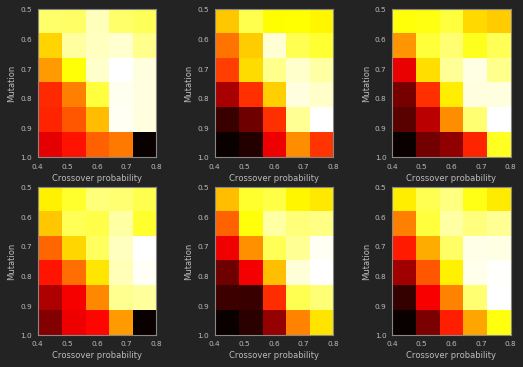

In [186]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(grid=False, fscale=0.7)



pm_80_20 = np.reshape(pm[::6], (6,5))/np.amax(pm)
pm_80_40 = np.reshape(pm[1::6], (6,5))/np.amax(pm)
pm_160_20 = np.reshape(pm[2::6], (6,5))/np.amax(pm)
pm_160_40 = np.reshape(pm[3::6], (6,5))/np.amax(pm)
pm_320_20 = np.reshape(pm[4::6], (6,5))/np.amax(pm)
pm_320_40 = np.reshape(pm[5::6], (6,5))/np.amax(pm)

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(231)
d2 = ax.imshow(pm_80_20, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

ax1 = fig.add_subplot(232)
d2 = ax1.imshow(pm_160_20, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

ax2 = fig.add_subplot(233)
d2 = ax2.imshow(pm_320_20, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

ax3 = fig.add_subplot(234)
d2 = ax3.imshow(pm_80_40, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

ax4 = fig.add_subplot(235)
d2 = ax4.imshow(pm_160_40, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

ax5 = fig.add_subplot(236)
d2 = ax5.imshow(pm_320_40, cmap="hot_r", interpolation='none', extent=[0.4, 0.8, 1.0, 0.5] )
plt.xlabel('Crossover probability')
plt.ylabel('Mutation')

#plt.colorbar(mappable=d2)
plt.show()

In [ ]:
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]

psize = 320
targ_spec2 = np.tile(targ_spec, (psize,1))
its_first = 500
psnew = 20
its_second = 300
reps = 100


run_hist = []
run_time1 = []
run_time2 = []
run_time_tot = []
run_pmre = []
run_best = []

for rep in range(reps):
    print("iteration ", rep)
    start = time.time()
    pop, f, b, hstry = de.de_g(fobj=ld.mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first, target=targ_spec2, mxmodel=mod) 
    #pop, f, b, hstry = de2(fobj=mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first) 
    end1 = time.time()
    marg = int(psnew/5)
    pnew1 = pop[np.argsort(f)][:psnew-marg]
    pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
    pnew = np.concatenate((pnew1, pnew2))
    #b, c, hstry = de_stage2(fobj=loss_func, bounds=bnds, popint=pnew, history=hstry, itprev=its_first, popsize=psnew, its=its_second)
   # b, c, hstry = de.de_c(fobj=loss_func, bounds=bnds,  popsize=80, its=500)
    b, c, hstry = de.de_c(fobj=ld.loss_func, bounds=bnds, pop=pnew, history=hstry, it_start=its_first, popsize=psnew, its=its_second, target=targ_spec, mats=mats, lams=lams)
    end = time.time()
    run_time1.append((end1 - start)/60.0)
    run_time2.append((end - end1)/60.0)
    run_time_tot.append((end - start)/60.0)
    run_pmre.append(c)
    run_best.append(b)
    run_hist.append(np.asarray(hstry))


In [ ]:
pm, pstd, rm, rstd

In [ ]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='monokai')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
jtplot.style(grid=False, figsize=(4,2), fscale=0.7, s)
# reset default matplotlib rcParams
#jtplot.reset()
plt.s
plt.hist(run_pmre, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2.5, 3], density=True, stacked=True)

In [ ]:
fig, ax = plt.subplots()
ax.hist(run_pmre, bins=np.linspace(0, 2, 33), density=True, stacked=True, histtype='stepfilled')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0.0)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

In [ ]:
a =np.arange(9)
a =np.reshape(a, (int(a.size/3),3))

In [ ]:
a[:,0]

In [162]:
a = np.arange(1,181)
a

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180])

In [164]:
a[::6]

array([  1,   7,  13,  19,  25,  31,  37,  43,  49,  55,  61,  67,  73,
        79,  85,  91,  97, 103, 109, 115, 121, 127, 133, 139, 145, 151,
       157, 163, 169, 175])

In [160]:
a[1::3]

array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50,
       53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89])

In [161]:
a[2::3]

array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90])